In [97]:
# use kernel fmri
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from nilearn.connectome import ConnectivityMeasure
from nilearn.input_data import NiftiLabelsMasker
from nilearn import datasets
from nilearn import image, plotting
from nilearn.glm.first_level import FirstLevelModel
from nilearn.glm import threshold_stats_img
from nilearn.datasets import load_mni152_template
from nilearn.plotting import plot_connectome, find_parcellation_cut_coords

from scipy import signal, stats

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score

In [33]:
print(f"Current directory: {os.getcwd()}")

Current directory: /Users/sdemirka/fmri/LPP


In [34]:
# Set up path
data_dir = "section1/" 
print(f"Current directory: {os.getcwd()}")

Current directory: /Users/sdemirka/fmri/LPP


In [35]:
# Loading files

subjects = {
    'CN1': 'sub-CN001_task-lppCN_run-04_bold.nii',
    'CN2': 'sub-CN002_task-lppCN_run-04_bold.nii',
    'CN3': 'sub-CN003_task-lppCN_run-05_bold.nii',
    'CN4': 'sub-CN004_task-lppCN_run-06_bold.nii',
    'CN5': 'sub-CN005_task-lppCN_run-05_bold.nii',
    'CN6': 'sub-CN006_task-lppCN_run-05_bold.nii',
    'CN7': 'sub-CN007_task-lppCN_run-09_bold.nii',
    'CN8': 'sub-CN008_task-lppCN_run-07_bold.nii',
    'CN9': 'sub-CN009_task-lppCN_run-05_bold.nii',
    'CN10': 'sub-CN010_task-lppCN_run-05_bold.nii',
    'CN11': 'sub-CN011_task-lppCN_run-05_bold.nii',
    'CN12': 'sub-CN013_task-lppCN_run-05_bold.nii',
    'CN13': 'sub-CN014_task-lppCN_run-05_bold.nii',
    'CN14': 'sub-CN015_task-lppCN_run-05_bold.nii',
    'CN15': 'sub-CN016_task-lppCN_run-05_bold.nii',
    'CN16': 'sub-CN017_task-lppCN_run-05_bold.nii',
    'CN17': 'sub-CN018_task-lppCN_run-05_bold.nii',
    'CN18': 'sub-CN019_task-lppCN_run-05_bold.nii',
    'CN19': 'sub-CN020_task-lppCN_run-05_bold.nii',
    'CN20': 'sub-CN021_task-lppCN_run-05_bold.nii',
    'CN21': 'sub-CN022_task-lppCN_run-05_bold.nii',
    'CN22': 'sub-CN023_task-lppCN_run-05_bold.nii',
    'CN23': 'sub-CN024_task-lppCN_run-05_bold.nii',
    'CN24': 'sub-CN025_task-lppCN_run-05_bold.nii',
    'CN25': 'sub-CN026_task-lppCN_run-05_bold.nii',
    
    'EN1': 'sub-EN057_task-lppEN_run-15_bold.nii',
    'EN2': 'sub-EN058_task-lppEN_run-08_bold.nii',
    'EN3': 'sub-EN059_task-lppEN_run-07_bold.nii',
    'EN4': 'sub-EN061_task-lppEN_run-09_bold.nii',
    'EN5': 'sub-EN062_task-lppEN_run-09_bold.nii',
    'EN6': 'sub-EN063_task-lppEN_run-07_bold.nii',
    'EN7': 'sub-EN064_task-lppEN_run-06_bold.nii',
    'EN8': 'sub-EN065_task-lppEN_run-08_bold.nii',
    'EN9': 'sub-EN067_task-lppEN_run-07_bold.nii',
    'EN10': 'sub-EN068_task-lppEN_run-08_bold.nii',
    'EN11': 'sub-EN069_task-lppEN_run-09_bold.nii',
    'EN12': 'sub-EN070_task-lppEN_run-07_bold.nii',
    'EN13': 'sub-EN072_task-lppEN_run-14_bold.nii',
    'EN14': 'sub-EN073_task-lppEN_run-09_bold.nii',
    'EN15': 'sub-EN074_task-lppEN_run-07_bold.nii',
    'EN16': 'sub-EN075_task-lppEN_run-09_bold.nii',
    'EN17': 'sub-EN076_task-lppEN_run-06_bold.nii',
    'EN18': 'sub-EN077_task-lppEN_run-08_bold.nii',
    'EN19': 'sub-EN078_task-lppEN_run-06_bold.nii',
    'EN20': 'sub-EN079_task-lppEN_run-08_bold.nii',
    'EN21': 'sub-EN081_task-lppEN_run-06_bold.nii',
    'EN22': 'sub-EN082_task-lppEN_run-06_bold.nii',
    'EN23': 'sub-EN083_task-lppEN_run-08_bold.nii',
    'EN24': 'sub-EN084_task-lppEN_run-09_bold.nii',
    'EN25': 'sub-EN086_task-lppEN_run-06_bold.nii',
}

# Load the 4D images for each subject
img_4d_data = {}

for subject_id, filename in subjects.items():
    
    filepath = os.path.join(data_dir, filename)
    
    img_4d_data[subject_id] = image.load_img(filepath)


In [30]:
img_4d_data['CN25'].shape

(73, 90, 74, 283)

In [31]:
# Load brain atlas to define regions
atlas = datasets.fetch_atlas_schaefer_2018(n_rois=100, yeo_networks=7, resolution_mm=2)

# Create a masker using the atlas
atlas_masker = NiftiLabelsMasker(
    labels_img=atlas.maps,
    labels=atlas.labels,
    standardize=True,
    detrend=True,
    low_pass=0.1,
    high_pass=0.01,
    t_r=2.0,
    memory='nilearn_cache',
    memory_level=1,
    verbose=1
)

[get_dataset_dir] Dataset found in /Users/sdemirka/nilearn_data/schaefer_2018

/var/folders/s_/80g5k_kd3jnc0g5vz4xlf24n5901wp/T/ipykernel_17410/3065917771.py:10: UserWarning: 'labels' must be a list. Got: <class 'numpy.ndarray'>
  atlas_masker = NiftiLabelsMasker(
/var/folders/s_/80g5k_kd3jnc0g5vz4xlf24n5901wp/T/ipykernel_17410/3065917771.py:10: UserWarning: All elements of 'labels' must be a string.
Got a list of {<class 'numpy.bytes_'>}
  atlas_masker = NiftiLabelsMasker(
/var/folders/s_/80g5k_kd3jnc0g5vz4xlf24n5901wp/T/ipykernel_17410/3065917771.py:10: UserWarning: Mismatch between the number of provided labels (100) and the number of regions in provided label image (101).
  atlas_masker = NiftiLabelsMasker(


In [40]:
# Regional time series from each brain region

regional_time_series = {}

for subject_id, nifti_img in img_4d_data.items():
    
    # Extract time series for each of the 100 brain regions
    time_series = atlas_masker.fit_transform(nifti_img)
    regional_time_series[subject_id] = time_series


[NiftiLabelsMasker.wrapped] loading data from 
/Users/sdemirka/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_2mm.nii.gz

/Users/sdemirka/fmri/lib/python3.13/site-packages/nilearn/maskers/base_masker.py:282: UserWarning: Mismatch between the number of provided labels (100) and the number of regions in provided label image (101).
Note that this may be due to some regions being dropped from the label image after resampling.
  return self.transform_single_imgs(


[NiftiLabelsMasker.wrapped] loading data from 
/Users/sdemirka/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_2mm.nii.gz

[NiftiLabelsMasker.wrapped] loading data from 
/Users/sdemirka/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_2mm.nii.gz

[NiftiLabelsMasker.wrapped] loading data from 
/Users/sdemirka/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_2mm.nii.gz

[NiftiLabelsMasker.wrapped] loading data from 
/Users/sdemirka/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_2mm.nii.gz

[NiftiLabelsMasker.wrapped] loading data from 
/Users/sdemirka/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_2mm.nii.gz

[NiftiLabelsMasker.wrapped] loading data from 
/Users/sdemirka/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_2mm.nii.gz

[NiftiLabelsMasker.wrapped] loading data from 
/Users/sdemirka/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_2mm.nii.gz

[NiftiLabelsMasker.wrapped] loading data from 
/Users/sdemirka/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_2mm.nii.gz

[NiftiLabelsMasker.wrapped] loading data from 
/Users/sdemirka/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_2mm.nii.gz

[NiftiLabelsMasker.wrapped] loading data from 
/Users/sdemirka/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_2mm.nii.gz

[NiftiLabelsMasker.wrapped] loading data from 
/Users/sdemirka/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_2mm.nii.gz

[NiftiLabelsMasker.wrapped] loading data from 
/Users/sdemirka/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_2mm.nii.gz

[NiftiLabelsMasker.wrapped] loading data from 
/Users/sdemirka/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_2mm.nii.gz

[NiftiLabelsMasker.wrapped] loading data from 
/Users/sdemirka/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_2mm.nii.gz

[NiftiLabelsMasker.wrapped] loading data from 
/Users/sdemirka/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_2mm.nii.gz

[NiftiLabelsMasker.wrapped] loading data from 
/Users/sdemirka/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_2mm.nii.gz

[NiftiLabelsMasker.wrapped] loading data from 
/Users/sdemirka/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_2mm.nii.gz

[NiftiLabelsMasker.wrapped] loading data from 
/Users/sdemirka/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_2mm.nii.gz

[NiftiLabelsMasker.wrapped] loading data from 
/Users/sdemirka/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_2mm.nii.gz

[NiftiLabelsMasker.wrapped] loading data from 
/Users/sdemirka/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_2mm.nii.gz

[NiftiLabelsMasker.wrapped] loading data from 
/Users/sdemirka/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_2mm.nii.gz

[NiftiLabelsMasker.wrapped] loading data from 
/Users/sdemirka/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_2mm.nii.gz

[NiftiLabelsMasker.wrapped] loading data from 
/Users/sdemirka/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_2mm.nii.gz

[NiftiLabelsMasker.wrapped] loading data from 
/Users/sdemirka/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_2mm.nii.gz

[NiftiLabelsMasker.wrapped] loading data from 
/Users/sdemirka/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_2mm.nii.gz

[NiftiLabelsMasker.wrapped] loading data from 
/Users/sdemirka/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_2mm.nii.gz

[NiftiLabelsMasker.wrapped] loading data from 
/Users/sdemirka/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_2mm.nii.gz

[NiftiLabelsMasker.wrapped] loading data from 
/Users/sdemirka/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_2mm.nii.gz

[NiftiLabelsMasker.wrapped] loading data from 
/Users/sdemirka/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_2mm.nii.gz

[NiftiLabelsMasker.wrapped] loading data from 
/Users/sdemirka/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_2mm.nii.gz

[NiftiLabelsMasker.wrapped] loading data from 
/Users/sdemirka/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_2mm.nii.gz

[NiftiLabelsMasker.wrapped] loading data from 
/Users/sdemirka/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_2mm.nii.gz

[NiftiLabelsMasker.wrapped] loading data from 
/Users/sdemirka/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_2mm.nii.gz

[NiftiLabelsMasker.wrapped] loading data from 
/Users/sdemirka/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_2mm.nii.gz

[NiftiLabelsMasker.wrapped] loading data from 
/Users/sdemirka/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_2mm.nii.gz

[NiftiLabelsMasker.wrapped] loading data from 
/Users/sdemirka/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_2mm.nii.gz

[NiftiLabelsMasker.wrapped] loading data from 
/Users/sdemirka/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_2mm.nii.gz

[NiftiLabelsMasker.wrapped] loading data from 
/Users/sdemirka/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_2mm.nii.gz

[NiftiLabelsMasker.wrapped] loading data from 
/Users/sdemirka/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_2mm.nii.gz

[NiftiLabelsMasker.wrapped] loading data from 
/Users/sdemirka/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_2mm.nii.gz

[NiftiLabelsMasker.wrapped] loading data from 
/Users/sdemirka/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_2mm.nii.gz

[NiftiLabelsMasker.wrapped] loading data from 
/Users/sdemirka/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_2mm.nii.gz

[NiftiLabelsMasker.wrapped] loading data from 
/Users/sdemirka/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_2mm.nii.gz

[NiftiLabelsMasker.wrapped] loading data from 
/Users/sdemirka/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_2mm.nii.gz

[NiftiLabelsMasker.wrapped] loading data from 
/Users/sdemirka/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_2mm.nii.gz

[NiftiLabelsMasker.wrapped] loading data from 
/Users/sdemirka/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_2mm.nii.gz

[NiftiLabelsMasker.wrapped] loading data from 
/Users/sdemirka/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_2mm.nii.gz

[NiftiLabelsMasker.wrapped] loading data from 
/Users/sdemirka/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_2mm.nii.gz

[NiftiLabelsMasker.wrapped] loading data from 
/Users/sdemirka/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_2mm.nii.gz

In [43]:
 regional_time_series['EN25'] # shape (n_timepoints, 100) 

array([[-0.02357753, -0.04815276,  0.02736692, ...,  0.0958518 ,
         0.03175383,  0.04049539],
       [ 1.2162502 , -0.52890396,  0.5500706 , ...,  0.17521314,
         0.63070613,  1.1826293 ],
       [ 1.4184076 , -1.3887494 ,  0.2891207 , ..., -0.16427284,
         0.35133848,  1.4121964 ],
       ...,
       [ 1.0913178 ,  0.29919252,  0.34393305, ...,  0.39294258,
         1.2343836 ,  1.9622396 ],
       [ 0.67872113,  0.4100077 ,  0.21303502, ...,  0.5004729 ,
         0.8462071 ,  1.4762133 ],
       [-0.22893535, -0.38335785, -0.45317864, ...,  0.09715392,
        -0.35697445, -0.17906103]], shape=(282, 100), dtype=float32)

In [53]:
# Create an instance of .ConnectivityMeasure class 

connectivity_measure = ConnectivityMeasure(
    kind='correlation',  # Pearson correlation
    discard_diagonal=True  # Remove self-connections 
)

connectivity_measure


ConnectivityMeasure(discard_diagonal=True, kind='correlation')

In [54]:
# Connectivity matrices 

connectivity_matrices = {}

for subject_id, time_series in regional_time_series.items():
    
    # Compute 100x100 correlation matrix between brain regions
    conn_matrix = connectivity_measure.fit_transform([time_series])[0]
    connectivity_matrices[subject_id] = conn_matrix
    

In [55]:
connectivity_matrices["EN25"]

array([[ 1.        , -0.02373124,  0.07294386, ...,  0.5340529 ,
         0.47039592,  0.3722134 ],
       [-0.02373124,  1.        ,  0.69377846, ..., -0.02520091,
         0.474497  , -0.00958749],
       [ 0.07294386,  0.69377846,  1.        , ...,  0.08213706,
         0.7653031 ,  0.16194385],
       ...,
       [ 0.5340529 , -0.02520091,  0.08213706, ...,  1.        ,
         0.39617905,  0.47146344],
       [ 0.47039592,  0.474497  ,  0.7653031 , ...,  0.39617905,
         1.        ,  0.38401833],
       [ 0.3722134 , -0.00958749,  0.16194385, ...,  0.47146344,
         0.38401833,  1.        ]], shape=(100, 100), dtype=float32)

In [56]:
def matrix_to_features(conn_matrix):
    
    # Get upper triangle indices (excluding diagonal)
    upper_tri_indices = np.triu_indices(conn_matrix.shape[0], k=1)
    
    # Extract upper triangle values as feature vector
    return conn_matrix[upper_tri_indices]

# Prepare features and labels

X = []  # Features (connectivity patterns)

y_subject = []  # Subject labels

y_language = []  # Language labels

for subject_id, conn_matrix in connectivity_matrices.items():
    
    # Convert matrix to feature vector
    features = matrix_to_features(conn_matrix)
    X.append(features)
    
    # Add labels
    y_subject.append(subject_id)
    if subject_id.startswith('CN'):
        y_language.append('Chinese')
    else:
        y_language.append('English')

X = np.array(X)
y_subject = np.array(y_subject)
y_language = np.array(y_language)


In [80]:
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# CHINESE vs ENGLISH classification with Random Forest
clf_language = RandomForestClassifier(n_estimators=100, random_state=42)

# Cross-validation with stratified k-fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
language_scores = cross_val_score(clf_language, X_scaled, y_language, cv=cv, scoring='accuracy')

print(f"Language Classification Accuracy: {language_scores.mean():.3f} ± {language_scores.std():.3f}")
print(f"Individual fold scores: {language_scores}")
print(f"Chance level: 50.0%")


# Train model
clf_language.fit(X_scaled, y_language)

# Statistical test
t_stat, p_value = stats.ttest_1samp(language_scores, 0.5)
print(f"\nStatistical significance test (vs chance):")
print(f"  T-statistic: {t_stat:.4f}")
print(f"  P-value: {p_value:.6f}")
if p_value < 0.001:
    print("  Highly significant (p < 0.001)")
elif p_value < 0.01:
    print("  Very significant (p < 0.01)")
elif p_value < 0.05:

    print("  Significant (p < 0.05)")
else:
    print("  Not significant")

Language Classification Accuracy: 0.800 ± 0.063
Individual fold scores: [0.7 0.8 0.8 0.9 0.8]
Chance level: 50.0%

Statistical significance test (vs chance):
  T-statistic: 9.4868
  P-value: 0.000689
  Highly significant (p < 0.001)


In [81]:
# Get feature importance from your trained Random Forest
feature_importance = clf_language.feature_importances_
# Find top discriminative connections
top_connections = np.argsort(feature_importance)[::-1][:20]  # Top 20

In [82]:
top_connections

array([1352, 2966, 2184, 2470, 1051, 1813, 2791, 1724, 2256, 4597, 3598,
       1327, 1816, 1434, 3517,  263, 2858, 1802, 3273, 3614])

In [83]:
# Convert linear indices back to (i,j) ROI pairs
def feature_to_roi_pair(feature_idx, n_rois=100):
    """
    Convert linear feature index back to (i,j) ROI pair indices.
    
    Parameters:
    feature_idx: int, linear index in the upper triangle feature vector
    n_rois: int, number of ROIs (default 100)
    
    Returns:
    tuple: (i, j) where i < j are the ROI indices
    """
    # Get upper triangle indices (same as used in matrix_to_features)
    upper_tri_indices = np.triu_indices(n_rois, k=1)
    
    # Convert feature index to (i,j) pair
    i = upper_tri_indices[0][feature_idx]
    j = upper_tri_indices[1][feature_idx]
    
    return i, j

# Get feature importance from trained Random Forest
feature_importance = clf_language.feature_importances_

# Find top discriminative connections
n_top = 20  # Number of top connections to examine
top_feature_indices = np.argsort(feature_importance)[::-1][:n_top]

print(f"Top {n_top} discriminative connections:")
print("Rank | Conn# | ROI1 | ROI2 | Importance | ROI1 Label | ROI2 Label")
print("-" * 95)

for rank, feature_idx in enumerate(top_feature_indices, 1):
    i, j = feature_to_roi_pair(feature_idx)
    importance = feature_importance[feature_idx]
    
    # Get ROI labels (assuming you have atlas.labels from earlier)
    roi1_label = atlas.labels[i].decode('utf-8') if hasattr(atlas.labels[i], 'decode') else atlas.labels[i]
    roi2_label = atlas.labels[j].decode('utf-8') if hasattr(atlas.labels[j], 'decode') else atlas.labels[j]
    
    print(f"{rank:4d} | {feature_idx:5d} | {i:4d} | {j:4d} | {importance:10.6f} | {roi1_label[:25]:<25} | {roi2_label[:25]}")

Top 20 discriminative connections:
Rank | Conn# | ROI1 | ROI2 | Importance | ROI1 Label | ROI2 Label
-----------------------------------------------------------------------------------------------
   1 |  1352 |   14 |   72 |   0.018156 | 7Networks_LH_SomMot_6     | 7Networks_RH_DorsAttn_FEF
   2 |  2966 |   36 |   69 |   0.015074 | 7Networks_LH_Cont_Cing_1  | 7Networks_RH_DorsAttn_Pos
   3 |  2184 |   25 |   35 |   0.013410 | 7Networks_LH_SalVentAttn_ | 7Networks_LH_Cont_pCun_1
   4 |  2470 |   29 |   35 |   0.013060 | 7Networks_LH_SalVentAttn_ | 7Networks_LH_Cont_pCun_1
   5 |  1051 |   11 |   29 |   0.011550 | 7Networks_LH_SomMot_3     | 7Networks_LH_SalVentAttn_
   6 |  1813 |   20 |   44 |   0.010883 | 7Networks_LH_DorsAttn_Pos | 7Networks_LH_Default_PFC_
   7 |  2791 |   33 |   86 |   0.010873 | 7Networks_LH_Cont_Par_1   | 7Networks_RH_Cont_Cing_1
   8 |  1724 |   19 |   34 |   0.009911 | 7Networks_LH_DorsAttn_Pos | 7Networks_LH_Cont_PFCl_1
   9 |  2256 |   26 |   34 |   0.009717

In [87]:
# Examine correlation directions for top connections
print("Correlation directions for top discriminative connections:")
print("Rank | Conn# | ROI1 | ROI2 | CN_mean | EN_mean | Diff(CN-EN) | Direction")
print("-" * 90)

for rank, feature_idx in enumerate(top_feature_indices[:20], 1):  # Top 10 for clarity
    i, j = feature_to_roi_pair(feature_idx)
    
    # Get correlation values for this connection across subjects
    cn_correlations = []
    en_correlations = []
    
    for subject_id in connectivity_matrices.keys():
        conn_value = connectivity_matrices[subject_id][i, j]
        if subject_id.startswith('CN'):
            cn_correlations.append(conn_value)
        else:
            en_correlations.append(conn_value)
    
    cn_mean = np.mean(cn_correlations)
    en_mean = np.mean(en_correlations)
    diff = cn_mean - en_mean
    
    direction = "CN > EN" if diff > 0 else "EN > CN"
    
    print(f"{rank:4d} | {feature_idx:5d} | {i:4d} | {j:4d} | {cn_mean:7.3f} | {en_mean:7.3f} | {diff:8.3f} | {direction}")



Correlation directions for top discriminative connections:
Rank | Conn# | ROI1 | ROI2 | CN_mean | EN_mean | Diff(CN-EN) | Direction
------------------------------------------------------------------------------------------
   1 |  1352 |   14 |   72 |   0.279 |   0.573 |   -0.294 | EN > CN
   2 |  2966 |   36 |   69 |  -0.088 |   0.173 |   -0.261 | EN > CN
   3 |  2184 |   25 |   35 |   0.158 |   0.376 |   -0.218 | EN > CN
   4 |  2470 |   29 |   35 |  -0.110 |   0.165 |   -0.276 | EN > CN
   5 |  1051 |   11 |   29 |   0.453 |   0.665 |   -0.213 | EN > CN
   6 |  1813 |   20 |   44 |  -0.187 |   0.034 |   -0.221 | EN > CN
   7 |  2791 |   33 |   86 |   0.011 |   0.393 |   -0.382 | EN > CN
   8 |  1724 |   19 |   34 |  -0.139 |   0.232 |   -0.372 | EN > CN
   9 |  2256 |   26 |   34 |   0.264 |   0.453 |   -0.189 | EN > CN
  10 |  4597 |   72 |   98 |   0.118 |   0.331 |   -0.213 | EN > CN
  11 |  3598 |   47 |   74 |  -0.284 |  -0.042 |   -0.243 | EN > CN
  12 |  1327 |   14 |   47 | 

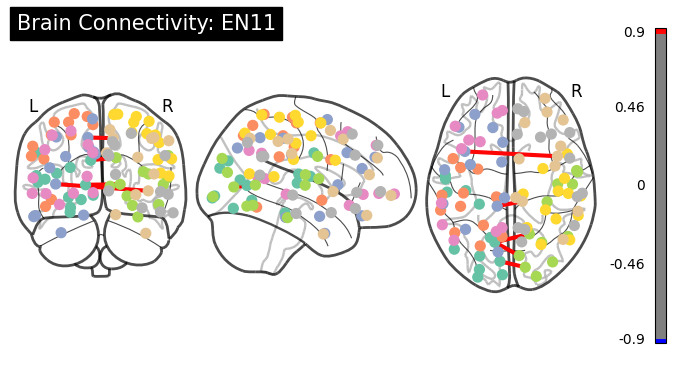

In [107]:
# Compute the coordinates from the atlas
coords = find_parcellation_cut_coords(labels_img=atlas.maps)


# Plotting the connectivity for a sample subject
sample_subject = list(connectivity_matrices.keys())[35]
conn_matrix = connectivity_matrices[sample_subject] # 100 x 100 connectivity matrix

# Only top 99.9% strongest connections are shown
# SPHERES = 100 brain regions
# LINE THICKNESS = connection strength
# LINE COLOR = red for strong, blue for weak

plot_connectome(conn_matrix, coords,
                edge_threshold="99.9%", 
                colorbar=True,
                title=f"Brain Connectivity: {sample_subject}")
plt.show()

# Interpretations
# Different connection patterns between Chinese and English?
# Strength differences in language-related regions
# Cross-hemispheric connections 

In [96]:
# Analyze functional networks for top Chinese and English dominant connections
print("Network Analysis for Top Discriminative Connections")
print("=" * 60)

# Extract network information from Schaefer labels
def get_network_from_label(label):
    """Extract network name from Schaefer atlas label"""
    if isinstance(label, bytes):
        label = label.decode('utf-8')
    
    # Schaefer labels format: "7Networks_LH_Vis_1" or "7Networks_RH_SomMot_1"
    parts = label.split('_')
    if len(parts) >= 3:
        return parts[2]  # Network name (e.g., 'Vis', 'SomMot', 'Limbic')
    return 'Unknown'

def get_hemisphere_from_label(label):
    """Extract hemisphere from Schaefer atlas label"""
    if isinstance(label, bytes):
        label = label.decode('utf-8')
    
    parts = label.split('_')
    if len(parts) >= 2:
        return parts[1]  # 'LH' or 'RH'
    return 'Unknown'

# Top 2 Chinese dominant connections (CN > EN)
chinese_dominant = [
    (15, 3517, 45, 98, 0.132),  # (rank, conn#, roi1, roi2, diff)
    (20, 3614, 47, 90, 0.113)
]

# Top 2 English dominant connections (EN > CN) - taking the largest differences
english_dominant = [
    (7, 2791, 33, 86, -0.382),  # Largest EN advantage
    (8, 1724, 19, 34, -0.372)   # Second largest EN advantage
]

print("\n🇨🇳 TOP CHINESE DOMINANT CONNECTIONS:")
print("-" * 50)
for rank, conn_num, roi1, roi2, diff in chinese_dominant:
    roi1_label = atlas.labels[roi1]
    roi2_label = atlas.labels[roi2]
    
    roi1_network = get_network_from_label(roi1_label)
    roi2_network = get_network_from_label(roi2_label)
    roi1_hemi = get_hemisphere_from_label(roi1_label)
    roi2_hemi = get_hemisphere_from_label(roi2_label)
    
    print(f"Rank {rank} | Connection #{conn_num}")
    print(f"  ROI {roi1} ({roi1_hemi}): {roi1_label}")
    print(f"  ROI {roi2} ({roi2_hemi}): {roi2_label}")
    print(f"  Networks: {roi1_network} ↔ {roi2_network}")
    print(f"  Connection type: {'Within-network' if roi1_network == roi2_network else 'Between-network'}")
    print(f"  Hemisphere: {'Within-hemi' if roi1_hemi == roi2_hemi else 'Between-hemi'}")
    print(f"  CN advantage: +{diff:.3f}")
    print()

print("\n🇺🇸 TOP ENGLISH DOMINANT CONNECTIONS:")
print("-" * 50)
for rank, conn_num, roi1, roi2, diff in english_dominant:
    roi1_label = atlas.labels[roi1]
    roi2_label = atlas.labels[roi2]
    
    roi1_network = get_network_from_label(roi1_label)
    roi2_network = get_network_from_label(roi2_label)
    roi1_hemi = get_hemisphere_from_label(roi1_label)
    roi2_hemi = get_hemisphere_from_label(roi2_label)
    
    print(f"Rank {rank} | Connection #{conn_num}")
    print(f"  ROI {roi1} ({roi1_hemi}): {roi1_label}")
    print(f"  ROI {roi2} ({roi2_hemi}): {roi2_label}")
    print(f"  Networks: {roi1_network} ↔ {roi2_network}")
    print(f"  Connection type: {'Within-network' if roi1_network == roi2_network else 'Between-network'}")
    print(f"  Hemisphere: {'Within-hemi' if roi1_hemi == roi2_hemi else 'Between-hemi'}")
    print(f"  EN advantage: +{abs(diff):.3f}")
    print()

# Summary of network patterns
print("\n📊 NETWORK SUMMARY:")
print("-" * 30)
cn_networks = []
en_networks = []

for _, _, roi1, roi2, _ in chinese_dominant:
    cn_networks.extend([get_network_from_label(atlas.labels[roi1]), 
                       get_network_from_label(atlas.labels[roi2])])

for _, _, roi1, roi2, _ in english_dominant:
    en_networks.extend([get_network_from_label(atlas.labels[roi1]), 
                       get_network_from_label(atlas.labels[roi2])])

print(f"Chinese dominant networks: {set(cn_networks)}")
print(f"English dominant networks: {set(en_networks)}")

Network Analysis for Top Discriminative Connections

🇨🇳 TOP CHINESE DOMINANT CONNECTIONS:
--------------------------------------------------
Rank 15 | Connection #3517
  ROI 45 (LH): b'7Networks_LH_Default_PFC_5'
  ROI 98 (RH): b'7Networks_RH_Default_pCunPCC_1'
  Networks: Default ↔ Default
  Connection type: Within-network
  Hemisphere: Between-hemi
  CN advantage: +0.132

Rank 20 | Connection #3614
  ROI 47 (LH): b'7Networks_LH_Default_PFC_7'
  ROI 90 (RH): b'7Networks_RH_Default_Temp_1'
  Networks: Default ↔ Default
  Connection type: Within-network
  Hemisphere: Between-hemi
  CN advantage: +0.113


🇺🇸 TOP ENGLISH DOMINANT CONNECTIONS:
--------------------------------------------------
Rank 7 | Connection #2791
  ROI 33 (LH): b'7Networks_LH_Cont_Par_1'
  ROI 86 (RH): b'7Networks_RH_Cont_Cing_1'
  Networks: Cont ↔ Cont
  Connection type: Within-network
  Hemisphere: Between-hemi
  EN advantage: +0.382

Rank 8 | Connection #1724
  ROI 19 (LH): b'7Networks_LH_DorsAttn_Post_5'
  ROI 34